In [23]:
import numpy as np
from visualization import plot_spatio_temporal_data
class SampleDataset:
    '''
    basic deep hierarchical linear dstm
    Y_t is the soil moisture considering no precipitation
    Y_t = f(\theta_1, Y_{t-1}) + \eta_{1t}, where \eta_{1t} \sim Gau(0, R_{1t})

    S_t is the soil moisture including the precipitation
    Denote X_t be precipitation
    S_t = Y_t + f(\theta_2, X_t, X_{t-1}) + \eta_{2t}, where \eta_{2t} \sim Gau(0,R_{2t})

    the observation soil moisture is
    Z_t = Y_t + \epsilon_t, where \epsilon_t \sim Gau(0, R_{3t})




    '''

    def __init__(self, n, T, gamma, l, offset, total, frames_input, frames_output, warm_start_ind=0):
        self.Z = self.prepare_data(n, T, gamma, l, offset, total)
        self.frames_input = frames_input
        self.frames_output = frames_output
        self.warm_start_ind = warm_start_ind






    def prepare_data(self, n, T, gamma, l, offset, total):

        location_list = []
        for i in range(n):

            for j in range(n):

                location_list.append([i, j])
        location_list = np.array(location_list)
        #location_list = location_list.reshape(n, n, 2)

        distance_matrix_list = []
        for i in range(n*n):

            dist = np.array([np.sqrt(x[0]**2+x[1]**2) for x in location_list[i] - location_list])


            distance_matrix_list.append(dist)

        distance_matrix_list = np.array(distance_matrix_list)
        #distance_matrix_list = distance_matrix_list.reshape((n, n, n, n))


        weights_matrix = gamma * np.exp(-(distance_matrix_list + offset)**2 / l)
        

        w, _ = np.linalg.eig(weights_matrix)
        max_w = np.max(w)
        if max_w == 1 or max_w > 1:
            print("max eigen value is %f" % max_w)
            raise(ValueError("change initial parameters!"))
        else:
            print("max eigen value is %f" % max_w)
            print("valid initial parameters!")
            print(weights_matrix)


        sigma_eta = 0.1 * np.exp(-np.abs(distance_matrix_list) / 0.1)

        L1 = np.linalg.cholesky(sigma_eta).transpose()


        sigma_epsilon = 0.1 * np.exp(-np.abs(distance_matrix_list) / 0.1)
        L2 =  np.linalg.cholesky(sigma_epsilon).transpose()


        Z = np.zeros((n*n, T, total))
        Y = np.zeros((n*n, T, total))
        precipitation = np.random.randn(n*n, T, total) * 0
        for i in range(total):
            eta = np.dot(L1, np.random.randn(n*n, T))
            epsilon = np.dot(L2, np.random.randn(n*n, T))
            Y[:, 0, i] = precipitation[:, 0, i] + eta[:, 0] + 4
            #Z[:, 0, i] = Y[:, 0, i] + epsilon[:, 0]
            Z[:, 0, i] = Y[:, 0, i] 

            for t in range(1, T):

                if t == 1:
                    Y[:, t, i] = np.dot(weights_matrix, (Y[:, (t-1), i])[:, None]).ravel() + precipitation[:, t, i] + 0.1 * precipitation[:, t, i] + eta[:, t]
                else:
                    Y[:, t, i] = np.dot(weights_matrix, (Y[:, (t - 1), i])[:, None]).ravel() + np.dot(weights_matrix, (Y[:, (t - 2), i])[:, None]).ravel() * 0.5 + precipitation[:, t,
                                                                                               i] + 0.1 * precipitation[
                                                                                                          :, t,
                                                                                                          i] + eta[:, t]
                #Z[:, t, i] = Y[:, t, i] + epsilon[:, t]
                Z[:, t, i] = Y[:, t, i]

        Z = Z.reshape((n, n, T, total))
        Z = Z[..., None]
        Z = Z.transpose(3, 2, 4, 0, 1)


        return Z.astype(np.float32)

    def __len__(self):
        return self.Z.shape[0]

    def __getitem__(self, idx):

        Z = self.Z[idx, ...]
        input = Z[self.warm_start_ind:(self.warm_start_ind+self.frames_input), ...]
        output = Z[(self.warm_start_ind+self.frames_input): (self.warm_start_ind+self.frames_input+self.frames_output), ...]
        frozen = input[-1]
        return [idx, output, input, frozen, np.zeros(1)]




max eigen value is 0.552749
valid initial parameters!
[[6.17049020e-06 9.15781944e-04 1.83939721e-02 5.00000000e-02
  1.83939721e-02 9.15781944e-04 4.04428341e-03 2.78945372e-02
  4.87004839e-02 1.41633375e-02 1.83939721e-02 2.78945372e-02
  4.85495902e-02 3.46511411e-02 5.72497816e-03 5.00000000e-02
  4.87004839e-02 3.46511411e-02 1.06746004e-02 9.15781944e-04
  1.83939721e-02 1.41633375e-02 5.72497816e-03 9.15781944e-04
  4.29872595e-05]
 [9.15781944e-04 6.17049020e-06 9.15781944e-04 1.83939721e-02
  5.00000000e-02 4.04428341e-03 9.15781944e-04 4.04428341e-03
  2.78945372e-02 4.87004839e-02 2.78945372e-02 1.83939721e-02
  2.78945372e-02 4.85495902e-02 3.46511411e-02 4.87004839e-02
  5.00000000e-02 4.87004839e-02 3.46511411e-02 1.06746004e-02
  1.41633375e-02 1.83939721e-02 1.41633375e-02 5.72497816e-03
  9.15781944e-04]
 [1.83939721e-02 9.15781944e-04 6.17049020e-06 9.15781944e-04
  1.83939721e-02 2.78945372e-02 4.04428341e-03 9.15781944e-04
  4.04428341e-03 2.78945372e-02 4.85495902

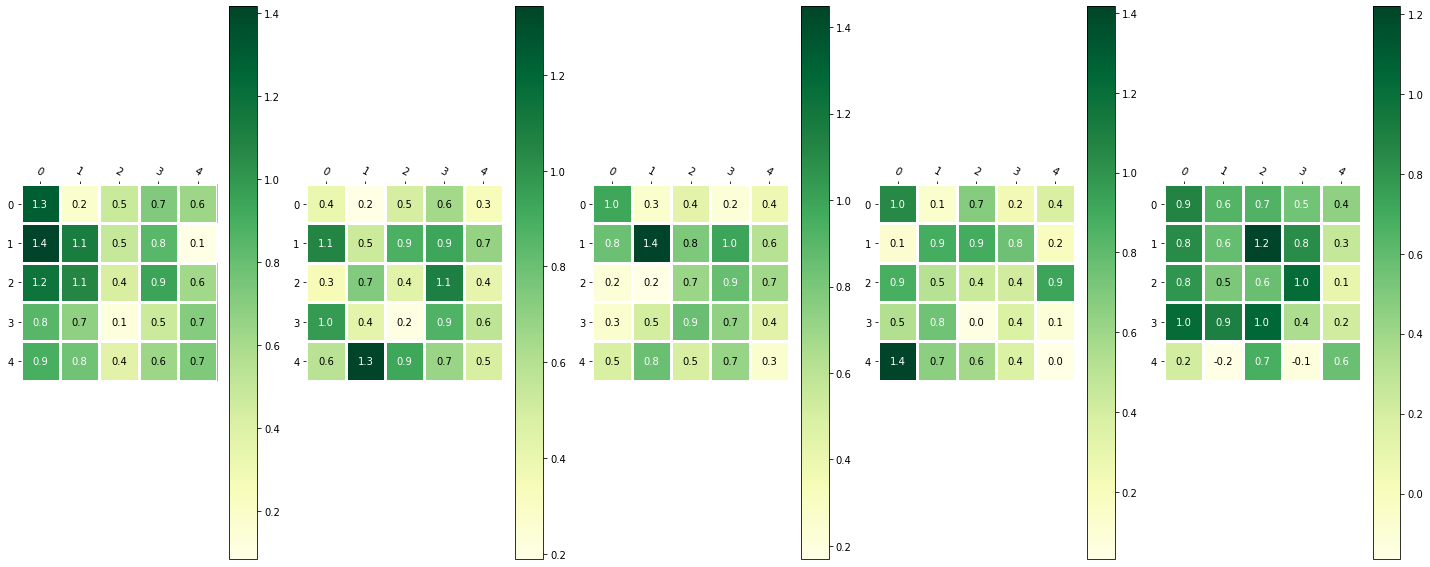

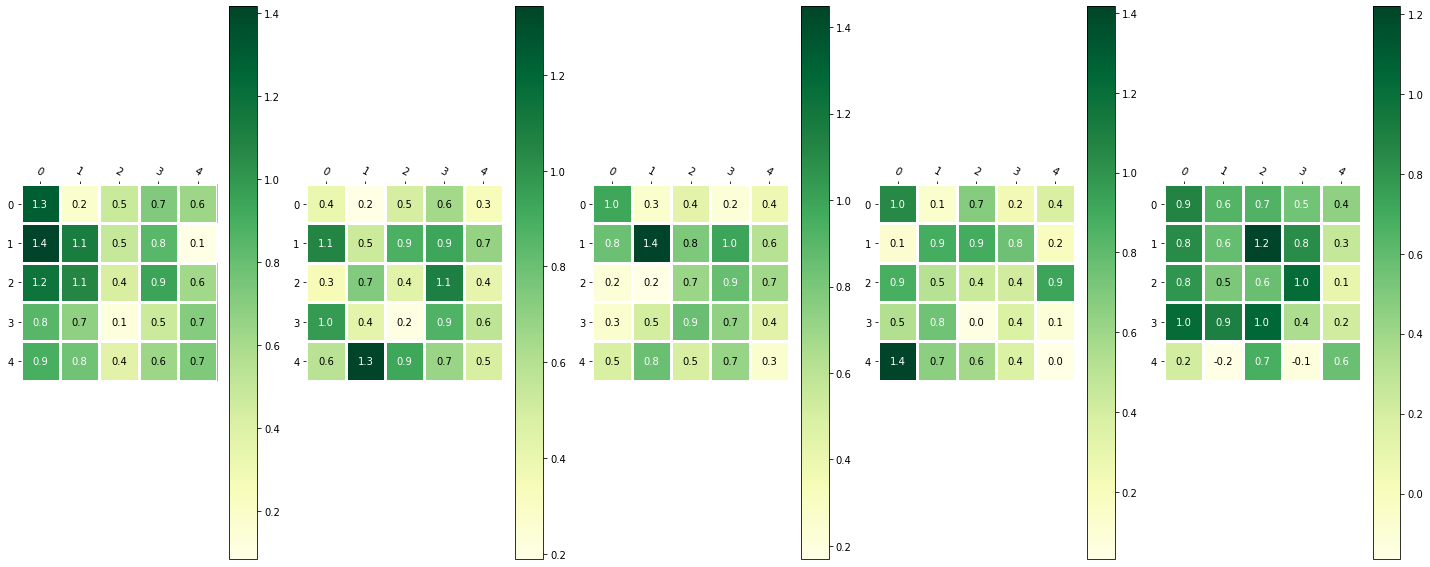

In [34]:
frames_input = 2
frames_output = 10
warm_start_ind = 3
T = 15

dm = SampleDataset(n=5, T=T, gamma=0.05, l=1, offset=-3, total=20, frames_input=frames_input, frames_output=frames_output, warm_start_ind=warm_start_ind)
print(dm.Z[0, ...])
plot_spatio_temporal_data(dm.Z[0, 10:15, ...].squeeze(1))

In [37]:
np.mean(abs(np.random.randn(100)))

0.7992393747354997